## Import Library

In [1]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import statistics

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Initialize Data

In [2]:
data_komentar = pd.read_csv('data/with_neutral_string.csv')
coments = data_komentar
coments

,id_komentar,sentimenc2,sentimenc2np,sentimenc3,komentar
0,4465,positive,positive,neutral,sepertinya tidak ada yang perlu dikritik
1,3922,positive,positive,positive,terimakasih sudah menjadi dosen yang mengerti ...
2,723,negative,negative,negative,untuk penjelasan meteri dan sebagainya mohon l...
3,2672,negative,negative,negative,seringnya perbatalan perkuliahan
4,3883,positive,positive,positive,menurut saya cara mengajar yang diterapkan sud...
...,...,...,...,...,...
4571,3364,negative,negative,negative,penjelasan disetiap materi kurang merinci maha...
4572,2287,positive,positive,positive,sudah bagus dalam penyampaian materi
4573,2622,negative,negative,negative,kualitas ajar yang kurang menyebabkan mahasisw...
4574,3315,positive,positive,positive,saya ngga ada kritik sama ibu pokoknya the bes...


## Fungsi untuk Preprocessing text

In [3]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    exclude_word = set(('tidak', 'bukan', 'kurang', 'belum', 'menyimpang', 'jangan', 'tak', 'tiada', 'engga', 'enggak', 'ndak', 'kagak'))
    finalStopword = listStopwords.difference(exclude_word)
    filtered = []
    for txt in text:
        if txt not in finalStopword:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [4]:
coments['text_clean'] = coments['komentar'].apply(cleaningText)
coments['text_clean']

0                sepertinya tidak ada yang perlu dikritik
1       terimakasih sudah menjadi dosen yang mengerti ...
2       untuk penjelasan meteri dan sebagainya mohon l...
3                        seringnya perbatalan perkuliahan
4       menurut saya cara mengajar yang diterapkan sud...
                              ...                        
4571    penjelasan disetiap materi kurang merinci maha...
4572                 sudah bagus dalam penyampaian materi
4573    kualitas ajar yang kurang menyebabkan mahasisw...
4574    saya ngga ada kritik sama ibu pokoknya the bes...
4575                       cara mengajar yang sangat baik
Name: text_clean, Length: 4576, dtype: object

In [5]:
coments['text_clean'] = coments['komentar'].apply(casefoldingText)
coments['text_clean']

0                sepertinya tidak ada yang perlu dikritik
1       terimakasih sudah menjadi dosen yang mengerti ...
2       untuk penjelasan meteri dan sebagainya mohon l...
3                        seringnya perbatalan perkuliahan
4       menurut saya cara mengajar yang diterapkan sud...
                              ...                        
4571    penjelasan disetiap materi kurang merinci maha...
4572                 sudah bagus dalam penyampaian materi
4573    kualitas ajar yang kurang menyebabkan mahasisw...
4574    saya ngga ada kritik sama ibu pokoknya the bes...
4575                       cara mengajar yang sangat baik
Name: text_clean, Length: 4576, dtype: object

In [6]:
coments.drop(['komentar'], axis = 1, inplace = True)

In [7]:
coments['text_preprocessed'] = coments['text_clean'].apply(tokenizingText)
coments['text_preprocessed']

0         [sepertinya, tidak, ada, yang, perlu, dikritik]
1       [terimakasih, sudah, menjadi, dosen, yang, men...
2       [untuk, penjelasan, meteri, dan, sebagainya, m...
3                    [seringnya, perbatalan, perkuliahan]
4       [menurut, saya, cara, mengajar, yang, diterapk...
                              ...                        
4571    [penjelasan, disetiap, materi, kurang, merinci...
4572           [sudah, bagus, dalam, penyampaian, materi]
4573    [kualitas, ajar, yang, kurang, menyebabkan, ma...
4574    [saya, ngga, ada, kritik, sama, ibu, pokoknya,...
4575                 [cara, mengajar, yang, sangat, baik]
Name: text_preprocessed, Length: 4576, dtype: object

In [8]:
coments['text_preprocessed'] = coments['text_preprocessed'].apply(filteringText)
coments['text_preprocessed']

0                                       [tidak, dikritik]
1               [terimakasih, dosen, mengerti, mahasiswa]
2         [penjelasan, meteri, mohon, diperjelas, ya, bu]
3                               [perbatalan, perkuliahan]
4                                  [mengajar, diterapkan]
                              ...                        
4571    [penjelasan, disetiap, materi, kurang, merinci...
4572                         [bagus, penyampaian, materi]
4573    [kualitas, ajar, kurang, menyebabkan, mahasisw...
4574    [ngga, kritik, pokoknya, the, best, buk, suka,...
4575                                           [mengajar]
Name: text_preprocessed, Length: 4576, dtype: object

In [9]:
coments['text_preprocessed'] = coments['text_preprocessed'].apply(stemmingText)
coments['text_preprocessed']

0                                         [tidak, kritik]
1                   [terimakasih, dosen, erti, mahasiswa]
2                    [jelas, meter, mohon, jelas, ya, bu]
3                                         [batal, kuliah]
4                                           [ajar, terap]
                              ...                        
4571    [jelas, tiap, materi, kurang, merinci, mahasis...
4572                              [bagus, sampai, materi]
4573    [kualitas, ajar, kurang, sebab, mahasiswa, tid...
4574    [ngga, kritik, pokok, the, best, buk, suka, ke...
4575                                               [ajar]
Name: text_preprocessed, Length: 4576, dtype: object

In [10]:
# drop duplicates/spams tweets
coments.drop_duplicates(subset = 'text_clean', inplace = True)

In [11]:
# Export to csv file
# coments.to_csv(r'data/coments_data_clean.csv', index = False, header = True,index_label=None)

# coments

## Analysis and Visualization

## Comparasion Class Sentiment on Data

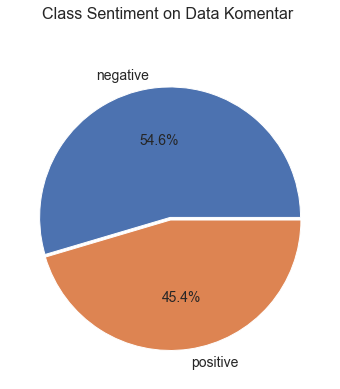

In [12]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in coments['sentimenc2'].value_counts()]
labels = list(coments['sentimenc2'].value_counts().index)
explode = (0.01, 0.01)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Class Sentiment on Data Komentar \n', fontsize = 16, pad = 20)
plt.show()

# Sentiment Analysis Using LSTM

## Preprocessing Text Data

In [13]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = coments['text_preprocessed'].apply(toSentence)
X

0                                            tidak kritik
1                        terimakasih dosen erti mahasiswa
2                           jelas meter mohon jelas ya bu
3                                            batal kuliah
4                                              ajar terap
                              ...                        
4571    jelas tiap materi kurang merinci mahasiswa tid...
4572                                  bagus sampai materi
4573    kualitas ajar kurang sebab mahasiswa tidak ert...
4574    ngga kritik pokok the best buk suka kelas ken ...
4575                                                 ajar
Name: text_preprocessed, Length: 4569, dtype: object

In [14]:
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)

X = tokenizer.texts_to_sequences(X.values)

X

[[3, 13],
 [22, 9, 12, 4],
 [16, 1211, 33, 16, 56, 21],
 [551, 7],
 [1, 182],
 [1, 1, 21, 552, 1],
 [199, 553],
 [3, 18, 13, 413, 846, 1],
 [14, 2, 18, 1212],
 [3, 847, 9],
 [19, 233],
 [3, 13, 24, 7, 18, 1, 17, 10, 2],
 [3, 247, 4, 23],
 [9, 11, 12, 4, 7],
 [63, 7, 135],
 [124, 5, 12, 212],
 [65],
 [67, 414, 37, 7, 72, 2, 20, 10],
 [1, 17, 12],
 [74, 40, 479],
 [82, 1],
 [25, 2, 113, 10],
 [13, 3, 248, 1, 480, 65, 1, 222, 177, 131, 280, 1, 32, 78, 154, 41],
 [2, 30, 93, 17, 10],
 [267, 1213, 35],
 [114, 3, 19, 14, 2],
 [848, 1],
 [554, 45, 555, 342, 8, 99, 21, 183],
 [680, 481, 19, 343, 1214, 281, 183],
 [70, 29, 10, 2, 849, 5, 309, 70, 1215, 103, 29],
 [3, 13, 21],
 [7, 482, 162, 72, 67, 2, 850, 150],
 [15, 75],
 [3, 38, 1216, 3, 851],
 [2, 282, 5, 200, 29, 141],
 [1217],
 [5, 1218, 124, 4, 283, 124, 136, 1219],
 [310, 75],
 [5, 4, 2, 18, 16],
 [5, 16, 2, 4, 3, 4, 6, 1220, 16, 2],
 [33, 2],
 [33, 51, 5, 852, 282, 45, 43, 81, 6],
 [1, 374, 22],
 [5, 4, 12, 483],
 [681, 2],
 [9, 57, 29

In [15]:
X = pad_sequences(X)
X

array([[   0,    0,    0, ...,    0,    3,   13],
       [   0,    0,    0, ...,    9,   12,    4],
       [   0,    0,    0, ...,   16,   56,   21],
       ...,
       [   0,    0,    0, ...,    3,   12,    2],
       [   0,    0,    0, ...,  173,   52, 2634],
       [   0,    0,    0, ...,    0,    0,    1]])

In [16]:
X.shape

(4569, 34)

In [17]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'positive' : 1}
y = coments['sentimenc2'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

## Model LSTM

In [18]:
# Create model function with default hyperparameter values

def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [19]:
# Results from hyperparameter tuning
results = pd.read_csv('data/gridsearchcv_results.csv')
results.sort_values(by='means', ascending = False).reset_index(drop=True)

,means,stds,params
0,0.916513,0.002494,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
1,0.916210,0.012881,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
2,0.915358,0.012066,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
3,0.915012,0.003830,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
4,0.912172,0.008714,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
...,...,...,...
283,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
284,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
285,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
286,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."


In [20]:
# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = RMSprop,
                        learning_rate = 0.001,
                   
                        # Fit Parameters
                        epochs=10, 
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)

In [21]:
scoring1 = ['accuracy', 'precision', 'recall', 'f1']

scoring = {'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
            }

In [22]:
cv_score = cross_validate(model, X, y, cv=5, scoring=scoring)
cv_score

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 32)            160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 271us/step - loss: 0.8869 - accuracy: 0.5470 - val_loss: 0.7476 - val_accuracy: 0.5137
Epoch 2/10
3289/3289 [==============================] - 0s 132us/step - loss: 0.7240 - accuracy: 0.5485 - val_loss: 0.6996 - val_accuracy: 0.5137
Epoch 3/10
3289/3289 [==============================] - 0s 130us/step - loss: 0.6694 - accuracy: 0.6312 - val_loss: 0.6493 - val_accuracy: 0.6831
Epoch 4/10
3289/3289 [==============================] - 0s 138us/step - loss: 0.6091 - accuracy: 0.7221 - val_loss: 0.6054 - val_accuracy: 0.6913
Epoch 5/10
3289/3289 [==============================] - 0s 135us/step - loss: 0.5382 - accuracy: 0.7866 - val_loss: 0.5502 - val_accuracy: 0.7295
Epoch 6/10
3289/3289 [==============================] - 0s 130us/step - loss: 0.4688 - accuracy: 0.8267 - val_loss: 0.4995 - val_accuracy: 0.7541
Epoch 7/10
3289/3289 [==============================] - 0s 128us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 237us/step - loss: 0.8841 - accuracy: 0.5412 - val_loss: 0.7266 - val_accuracy: 0.5137
Epoch 2/10
3289/3289 [==============================] - 0s 134us/step - loss: 0.7229 - accuracy: 0.5503 - val_loss: 0.6840 - val_accuracy: 0.5902
Epoch 3/10
3289/3289 [==============================] - 0s 136us/step - loss: 0.6567 - accuracy: 0.6455 - val_loss: 0.6235 - val_accuracy: 0.7158
Epoch 4/10
3289/3289 [==============================] - 0s 135us/step - loss: 0.5625 - accuracy: 0.7577 - val_loss: 0.5584 - val_accuracy: 0.7404
Epoch 5/10
3289/3289 [==============================] - 0s 133us/step - loss: 0.4904 - accuracy: 0.8018 - val_loss: 0.5065 - val_accuracy: 0.7732
Epoch 6/10
3289/3289 [==============================] - 0s 138us/step - loss: 0.4242 - accuracy: 0.8282 - val_loss: 0.4855 - val_accuracy: 0.7568
Epoch 7/10
3289/3289 [==============================] - 0s 134us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 248us/step - loss: 0.9379 - accuracy: 0.5391 - val_loss: 0.7404 - val_accuracy: 0.6749
Epoch 2/10
3289/3289 [==============================] - 0s 148us/step - loss: 0.6945 - accuracy: 0.6361 - val_loss: 0.6664 - val_accuracy: 0.6038
Epoch 3/10
3289/3289 [==============================] - 0s 147us/step - loss: 0.6163 - accuracy: 0.7036 - val_loss: 0.5948 - val_accuracy: 0.7213
Epoch 4/10
3289/3289 [==============================] - 0s 148us/step - loss: 0.5498 - accuracy: 0.7516 - val_loss: 0.5479 - val_accuracy: 0.7568
Epoch 5/10
3289/3289 [==============================] - 0s 141us/step - loss: 0.5012 - accuracy: 0.7850 - val_loss: 0.5151 - val_accuracy: 0.7705
Epoch 6/10
3289/3289 [==============================] - 0s 140us/step - loss: 0.4485 - accuracy: 0.8197 - val_loss: 0.5165 - val_accuracy: 0.7322
Epoch 7/10
3289/3289 [==============================] - 0s 139us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 233us/step - loss: 0.9185 - accuracy: 0.5382 - val_loss: 0.7557 - val_accuracy: 0.5219
Epoch 2/10
3289/3289 [==============================] - 0s 135us/step - loss: 0.7469 - accuracy: 0.5458 - val_loss: 0.6919 - val_accuracy: 0.6148
Epoch 3/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.6607 - accuracy: 0.6573 - val_loss: 0.6300 - val_accuracy: 0.7295
Epoch 4/10
3289/3289 [==============================] - 0s 150us/step - loss: 0.5707 - accuracy: 0.7513 - val_loss: 0.5568 - val_accuracy: 0.7541
Epoch 5/10
3289/3289 [==============================] - 0s 143us/step - loss: 0.4882 - accuracy: 0.7972 - val_loss: 0.5248 - val_accuracy: 0.7568
Epoch 6/10
3289/3289 [==============================] - 0s 137us/step - loss: 0.4310 - accuracy: 0.8234 - val_loss: 0.4907 - val_accuracy: 0.7923
Epoch 7/10
3289/3289 [==============================] - 0s 134us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3290 samples, validate on 366 samples
Epoch 1/10
3290/3290 [==============================] - 1s 240us/step - loss: 0.9302 - accuracy: 0.5650 - val_loss: 0.7416 - val_accuracy: 0.5792
Epoch 2/10
3290/3290 [==============================] - 0s 133us/step - loss: 0.7265 - accuracy: 0.5857 - val_loss: 0.6658 - val_accuracy: 0.7240
Epoch 3/10
3290/3290 [==============================] - 0s 131us/step - loss: 0.6523 - accuracy: 0.6790 - val_loss: 0.5941 - val_accuracy: 0.7705
Epoch 4/10
3290/3290 [==============================] - 0s 131us/step - loss: 0.5712 - accuracy: 0.7523 - val_loss: 0.5294 - val_accuracy: 0.7869
Epoch 5/10
3290/3290 [==============================] - 0s 132us/step - loss: 0.5025 - accuracy: 0.7891 - val_loss: 0.4850 - val_accuracy: 0.7814
Epoch 6/10
3290/3290 [==============================] - 0s 129us/step - loss: 0.4469 - accuracy: 0.8155 - val_loss: 0.4434 - val_accuracy: 0.8251
Epoch 7/10
3290/3290 [==============================] - 0s 129us/step - loss:

{'fit_time': array([6.05108404, 5.72362709, 6.18288779, 5.85727978, 5.80498362]),
 'score_time': array([0.15300465, 0.16814542, 0.15206504, 0.16400886, 0.15399671]),
 'test_accuracy': array([0.80853392, 0.81291028, 0.80306346, 0.79868709, 0.81161008]),
 'test_precision': array([0.81071512, 0.81392241, 0.81297404, 0.80390348, 0.81592896]),
 'test_recall': array([0.81365176, 0.81863324, 0.80742127, 0.80977843, 0.81355212]),
 'test_f1': array([0.80831341, 0.81237102, 0.80264673, 0.7982611 , 0.81144518])}

In [23]:
cv_pred = cross_val_predict(model, X, y, cv=5)
print("Accuracy Score",accuracy_score(y, cv_pred))
print("Precision Score",precision_score(y, cv_pred, average='macro'))
print("Recall Score",recall_score(y, cv_pred, average='macro'))
print("F1 Score",f1_score(y, cv_pred, average='macro'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 34, 32)            160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - ETA: 0s - loss: 0.9121 - accuracy: 0.49 - 1s 235us/step - loss: 0.9086 - accuracy: 0.4995 - val_loss: 0.7441 - val_accuracy: 0.5437
Epoch 2/10
3289/3289 [==============================] - 0s 134us/step - loss: 0.7292 - accuracy: 0.5555 - val_loss: 0.6882 - val_accuracy: 0.6858
Epoch 3/10
3289/3289 [==============================] - 0s 131us/step - loss: 0.6656 - accuracy: 0.6400 - val_loss: 0.6399 - val_accuracy: 0.6803
Epoch 4/10
3289/3289 [==============================] - 0s 133us/step - loss: 0.6010 - accuracy: 0.7099 - val_loss: 0.5973 - val_accuracy: 0.6913
Epoch 5/10
3289/3289 [==============================] - 0s 132us/step - loss: 0.5262 - accuracy: 0.7780 - val_loss: 0.5428 - val_accuracy: 0.7322
Epoch 6/10
3289/3289 [==============================] - 0s 136us/step - loss: 0.4626 - accuracy: 0.8081 - val_loss: 0.5043 - val_accuracy: 0.7568
Epoch 7/10
3289/3289 [=============

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 245us/step - loss: 0.8973 - accuracy: 0.5126 - val_loss: 0.7184 - val_accuracy: 0.5137
Epoch 2/10
3289/3289 [==============================] - 0s 140us/step - loss: 0.7173 - accuracy: 0.5442 - val_loss: 0.6875 - val_accuracy: 0.5301
Epoch 3/10
3289/3289 [==============================] - 0s 137us/step - loss: 0.6737 - accuracy: 0.6218 - val_loss: 0.6435 - val_accuracy: 0.6913
Epoch 4/10
3289/3289 [==============================] - 1s 153us/step - loss: 0.5865 - accuracy: 0.7224 - val_loss: 0.5784 - val_accuracy: 0.7213
Epoch 5/10
3289/3289 [==============================] - 1s 175us/step - loss: 0.4958 - accuracy: 0.7999 - val_loss: 0.5170 - val_accuracy: 0.7322
Epoch 6/10
3289/3289 [==============================] - 1s 202us/step - loss: 0.4215 - accuracy: 0.8313 - val_loss: 0.4832 - val_accuracy: 0.7814
Epoch 7/10
3289/3289 [==============================] - 0s 138us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 264us/step - loss: 0.9277 - accuracy: 0.5655 - val_loss: 0.7628 - val_accuracy: 0.5137
Epoch 2/10
3289/3289 [==============================] - 0s 146us/step - loss: 0.7350 - accuracy: 0.5789 - val_loss: 0.6942 - val_accuracy: 0.6749
Epoch 3/10
3289/3289 [==============================] - 0s 135us/step - loss: 0.6620 - accuracy: 0.6695 - val_loss: 0.6345 - val_accuracy: 0.7104
Epoch 4/10
3289/3289 [==============================] - 0s 135us/step - loss: 0.5826 - accuracy: 0.7446 - val_loss: 0.5780 - val_accuracy: 0.7404
Epoch 5/10
3289/3289 [==============================] - 0s 130us/step - loss: 0.5084 - accuracy: 0.7887 - val_loss: 0.5362 - val_accuracy: 0.7705
Epoch 6/10
3289/3289 [==============================] - 0s 130us/step - loss: 0.4517 - accuracy: 0.8151 - val_loss: 0.4983 - val_accuracy: 0.7732
Epoch 7/10
3289/3289 [==============================] - 0s 130us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 233us/step - loss: 0.9412 - accuracy: 0.5719 - val_loss: 0.7419 - val_accuracy: 0.5492
Epoch 2/10
3289/3289 [==============================] - 0s 132us/step - loss: 0.7143 - accuracy: 0.5667 - val_loss: 0.6804 - val_accuracy: 0.6721
Epoch 3/10
3289/3289 [==============================] - 0s 135us/step - loss: 0.6728 - accuracy: 0.6184 - val_loss: 0.6444 - val_accuracy: 0.6913
Epoch 4/10
3289/3289 [==============================] - 0s 136us/step - loss: 0.6122 - accuracy: 0.7081 - val_loss: 0.6081 - val_accuracy: 0.6995
Epoch 5/10
3289/3289 [==============================] - 0s 143us/step - loss: 0.5415 - accuracy: 0.7711 - val_loss: 0.5474 - val_accuracy: 0.7732
Epoch 6/10
3289/3289 [==============================] - 1s 153us/step - loss: 0.4793 - accuracy: 0.8100 - val_loss: 0.5073 - val_accuracy: 0.7732
Epoch 7/10
3289/3289 [==============================] - 0s 144us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3290 samples, validate on 366 samples
Epoch 1/10
3290/3290 [==============================] - 1s 239us/step - loss: 0.8731 - accuracy: 0.4578 - val_loss: 0.7219 - val_accuracy: 0.6858
Epoch 2/10
3290/3290 [==============================] - 0s 134us/step - loss: 0.7027 - accuracy: 0.5647 - val_loss: 0.6703 - val_accuracy: 0.6284
Epoch 3/10
3290/3290 [==============================] - 0s 137us/step - loss: 0.6679 - accuracy: 0.6106 - val_loss: 0.6430 - val_accuracy: 0.7240
Epoch 4/10
3290/3290 [==============================] - 0s 135us/step - loss: 0.6266 - accuracy: 0.6848 - val_loss: 0.5993 - val_accuracy: 0.7404
Epoch 5/10
3290/3290 [==============================] - 0s 137us/step - loss: 0.5826 - accuracy: 0.7401 - val_loss: 0.5571 - val_accuracy: 0.7923
Epoch 6/10
3290/3290 [==============================] - 0s 134us/step - loss: 0.5374 - accuracy: 0.7772 - val_loss: 0.5299 - val_accuracy: 0.7705
Epoch 7/10
3290/3290 [==============================] - 0s 133us/step - loss:

In [24]:
print("Accuracy each fold :", cv_score['test_accuracy'])
print("Precision each fold :", cv_score['test_precision'])
print("Recall each fold :", cv_score['test_recall'])
print("F1 each fold :", cv_score['test_f1'])

Accuracy each fold : [0.80853392 0.81291028 0.80306346 0.79868709 0.81161008]
Precision each fold : [0.81071512 0.81392241 0.81297404 0.80390348 0.81592896]
Recall each fold : [0.81365176 0.81863324 0.80742127 0.80977843 0.81355212]
F1 each fold : [0.80831341 0.81237102 0.80264673 0.7982611  0.81144518]


In [25]:
cv_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [26]:
conf_mat = confusion_matrix(y, cv_pred)
conf_mat

array([[2100,  394],
       [ 505, 1570]], dtype=int64)

In [27]:
print("Accuracy average :", cv_score['test_accuracy'].mean())
print("Precision average :", cv_score['test_precision'].mean())
print("Recall average :", cv_score['test_recall'].mean())
print("F1 average :", cv_score['test_f1'].mean())

Accuracy average : 0.8069609650058359
Precision average : 0.8114888044283793
Recall average : 0.8126073648701995
F1 average : 0.8066074884967186


In [28]:
print("Standard Deviation of Accuracy is % s " % (statistics.stdev(cv_score['test_accuracy'])))
print("Standard Deviation of Precision is % s " % (statistics.stdev(cv_score['test_precision'])))
print("Standard Deviation of Recall is % s " % (statistics.stdev(cv_score['test_recall'])))
print("Standard Deviation of F1 is % s " % (statistics.stdev(cv_score['test_f1'])))

Standard Deviation of Accuracy is 0.005981855840439781 
Standard Deviation of Precision is 0.004636243636512331 
Standard Deviation of Recall is 0.004277642592617991 
Standard Deviation of F1 is 0.006018335580860568 
